In [1]:
from mobilenet_v3 import MobileNet
import tensorflow as tf

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# import the necessary packages
from os import path

# since we do not have access to the testing data
# we need to take a number of images from the training data and use it instead
NUM_CLASSES = 200
NUM_TEST_IMAGES = 50 * NUM_CLASSES

# define the path to the output training, validation, and testing HDF5 files
TRAIN_HDF5 = "/home/ecbm4040/mobilenets-ecbm4040/data/hdf5/train.hdf5"
VAL_HDF5 = "/home/ecbm4040/mobilenets-ecbm4040/data/hdf5/val.hdf5"
TEST_HDF5 = "/home/ecbm4040/mobilenets-ecbm4040/data/hdf5/test.hdf5"

# define the path to the dataset mean
DATASET_MEAN = "/home/ecbm4040/mobilenets-ecbm4040/data/output/tiny-image-net-200-mean.json"

# define the path to the output directory used for storing plots, classification reports, etc.
OUTPUT_PATH = "output"
MODEL_PATH = path.sep.join([OUTPUT_PATH, "resnet_tinyimagenet.hdf5"])
FIG_PATH = path.sep.join([OUTPUT_PATH, "resnet56_tinyimagenet.png"])
JSON_PATH = path.sep.join([OUTPUT_PATH, "resnet56_tinyimagenet.json"])

In [4]:
from tensorflow.keras.preprocessing.image import img_to_array


class ImageToArrayPreprocessor:
    def __init__(self, data_format=None):
        # store the image data format
        self.data_format = data_format

    def preprocess(self, image):
        # apply the Keras utility function that correctly rearranges
        # the dimensions of the image
        return img_to_array(image, data_format=self.data_format)

In [5]:
import cv2


class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height, and interpolation method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect ratio
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [6]:
import cv2


class MeanPreprocessor:
    def __init__(self, r_mean, g_mean, b_mean):
        # store the Red, Green, and Blue channel averages across a training set
        self.r_mean = r_mean
        self.g_mean = g_mean
        self.b_mean = b_mean

    def preprocess(self, image):
        # split the image into its respective Red, Green, and Blue channels
        (B, G, R) = cv2.split(image.astype("float32"))

        # subtract the means for each channel
        R -= self.r_mean
        G -= self.g_mean
        B -= self.b_mean

        # merge the channels back together and return the image
        return cv2.merge([B, G, R])

In [7]:
from tensorflow.keras.callbacks import Callback
import os


class EpochCheckpoint(Callback):
    def __init__(self, output_path, every=5, start_at=0):
        # call the parent constructor
        super(Callback, self).__init__()

        # store the base output path for the model, the number of
        # epochs that must pass before the model is serialized to
        # disk and the current epoch value
        self.output_path = output_path
        self.every = every
        self.int_epoch = start_at

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # check to see if the model should be serialized to disk
        if (self.int_epoch + 1) % self.every == 0:
            p = os.path.sep.join([self.output_path, "epoch_{}.hdf5".format(self.int_epoch + 1)])
            self.model.save(p, overwrite=True)

        # increment the internal epoch counter
        self.int_epoch += 1

In [8]:
from tensorflow.keras.callbacks import BaseLogger
import matplotlib.pyplot as plt
import numpy as np
import json
import os


class TrainingMonitor(BaseLogger):
    def __init__(self, fig_path, json_path=None, start_at=0):
        # store the output path for the figure, the path to the JSON serialized file, and the starting epoch
        super(TrainingMonitor, self).__init__()
        self.H = None
        self.fig_path = fig_path
        self.json_path = json_path
        self.start_at = start_at

    def on_train_begin(self, logs=None):
        # initialize the history dictionary
        if logs is None:
            logs = {}
        self.H = {}

        # if the JSON history path exists, load the training history
        if self.json_path is not None:
            if os.path.exists(self.json_path):
                self.H = json.loads(open(self.json_path).read())

                # check to see if a starting epoch was supplied
                if self.start_at > 0:
                    # loop over the entries in the history log and
                    # trim any entries that are past the starting
                    # epoch
                    for k in self.H.keys():
                        self.H[k] = self.H[k][:self.start_at]

    def on_epoch_end(self, epoch, logs=None):
        # loop over the logs and update the loss, accuracy, etc. for the entire training process
        if logs is None:
            logs = {}
        for (k, v) in logs.items():
            cur_list = self.H.get(k, [])
            cur_list.append(float(v))
            self.H[k] = cur_list

        # check to see if the training history should be serialized to file
        if self.json_path is not None:
            f = open(self.json_path, "w")
            f.write(json.dumps(self.H))
            f.close()

        # ensure at least two epochs have passed before plotting (epoch starts at zero)
        if len(self.H["loss"]) > 1:
            # plot the training loss and accuracy
            epochs = np.arange(0, len(self.H["loss"]))
            plt.style.use("ggplot")
            plt.figure(figsize=(16, 10))
            plt.plot(epochs, self.H["loss"], label="train_loss")
            plt.plot(epochs, self.H["val_loss"], label="val_loss")
            plt.plot(epochs, self.H["accuracy"], label="train_acc")
            plt.plot(epochs, self.H["val_accuracy"], label="val_acc")
            plt.title(f"Training Loss and Accuracy [Epoch {len(self.H['loss'])}]")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()

            # save the figure
            plt.savefig(self.fig_path)
            plt.close()

In [9]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import h5py


class HDF5DatasetGenerator:
    def __init__(self, db_path, batch_size, preprocessors=None, aug=None, binarize=True, classes=2):
        # store the batch size, preprocessors, and data augmentor, whether the labels should be binarized,
        # along with the total number of classes
        self.batch_size = batch_size
        self.preprocessors = preprocessors
        self.aug = aug
        self.binarize = binarize
        self.classes = classes

        # open the HDF5 database for reading and determine the total number of entries in the database
        self.db = h5py.File(db_path, "r")
        self.num_images = self.db["labels"].shape[0]

    def generator(self, passes=np.inf):
        # initialize the epoch count
        epochs = 0

        # keep looping infinitely -- the model will stop once we have reach the desired number of epochs
        while epochs < passes:
            # loop over the HDF5 dataset
            for i in np.arange(0, self.num_images, self.batch_size):
                # extract the images and labels from the HDF dataset
                images = self.db["images"][i: i + self.batch_size]
                labels = self.db["labels"][i: i + self.batch_size]

                # check to see if the labels should be binarized
                if self.binarize:
                    labels = to_categorical(labels, self.classes)

                # check to see if our preprocessors are not None
                if self.preprocessors is not None:
                    # initialize the list of processed images
                    proc_images = []

                    # loop over the images
                    for image in images:
                        # loop over the preprocessors and apply each to the image
                        for p in self.preprocessors:
                            image = p.preprocess(image)

                        # update the list of processed images
                        proc_images.append(image)

                    # update the images array to be the processed images
                    images = np.array(proc_images)

                # if the data augmentor exists, apply it
                if self.aug is not None:
                    (images, labels) = next(self.aug.flow(images, labels, batch_size=self.batch_size))
                # yield a tuple of images and labels
                yield images, labels
                
            # increment the total number of epochs
            epochs += 1

    def close(self):
        # close the database
        self.db.close()


In [10]:
import numpy as np


def rank5_accuracy(preds, labels):
    # initialize the rank-1 and rank-5 accuracies
    rank1 = 0
    rank5 = 0

    # loop over the predictions and ground-truth labels
    for (p, gt) in zip(preds, labels):
        # sort the probabilities by their index in descending order
        # so that the more confident guesses are at the front of the list
        p = np.argsort(p)[::-1]

        # check if the ground-truth label is in the top-5 predictions
        if gt in p[:5]:
            rank5 += 1

        # check to see if the ground-truth is the #1 prediction
        if gt == p[0]:
            rank1 += 1

    # compute the final rank-1 and rank-5 accuracies
    rank1 /= float(len(preds))
    rank5 /= float(len(preds))

    # return a tuple of the rank-1 and rank-5 accuracies
    return rank1, rank5

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import argparse
import json
import sys
import os


In [12]:
# define the total number of epochs to train for along with the initial learning rate
NUM_EPOCHS = 75
INIT_LR = 1e-1

In [13]:
args = {
    'model': MODEL_PATH,  # path to output model
    'output': 'output',  # path to output directory (logs, plots, etc.)
}

In [14]:
def poly_decay(epoch):
    # initialize the maximum number of epochs, base learning rate,
    # and power of the polynomial
    max_epochs = NUM_EPOCHS
    base_lr = INIT_LR
    power = 1.0

    # compute the new learning rate based on polynomial decay
    alpha = base_lr * (1 - (epoch / float(max_epochs))) ** power

    # return the new learning rate
    return alpha

In [15]:
aug = ImageDataGenerator(
    rotation_range=18, 
    zoom_range=0.15, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.15, 
    horizontal_flip=True, 
    fill_mode="nearest"
)

In [16]:
means = json.loads(open(DATASET_MEAN).read())
means

{'R': 122.40461138237848, 'G': 114.18276671820746, 'B': 101.30663024902344}

In [17]:
sp = SimplePreprocessor(224, 224)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
iap = ImageToArrayPreprocessor()

In [18]:
train_gen = HDF5DatasetGenerator(TRAIN_HDF5, 64, aug=aug, preprocessors=[sp, mp, iap], classes=NUM_CLASSES)
val_gen = HDF5DatasetGenerator(VAL_HDF5, 64, preprocessors=[sp, mp, iap], classes=NUM_CLASSES)

In [19]:
fig_path = os.path.sep.join([args["output"], "{}.png".format(os.getpid())])
json_path = os.path.sep.join([args["output"], "{}.json".format(os.getpid())])
callbacks = [
    # TrainingMonitor(fig_path, json_path=json_path),
    LearningRateScheduler(poly_decay)
]

In [20]:
mobilenet = MobileNet(
    num_classes = NUM_CLASSES,
    alpha = 1, 
    input_shape_ = (224, 224, 3)
)

mobilenet.build(input_shape = (None, 224, 224, 3))

In [21]:
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam

def top_5_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=5)

mobilenet.compile(
    optimizer = Adam(lr=INIT_LR), 
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy', top_5_accuracy]
)
#mobilenet.summary()

In [22]:
mobilenet.make()

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 112, 112, 32)      0     

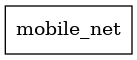

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(mobilenet, to_file='mobilenet.png', show_shapes=True)

In [ ]:
print("[INFO] training network...")
H = mobilenet.fit(
    train_gen.generator(),
    steps_per_epoch=train_gen.num_images // 64,
    validation_data=val_gen.generator(),
    validation_steps=val_gen.num_images // 64,
    epochs=NUM_EPOCHS,
    max_queue_size=10,
    callbacks=callbacks, 
    verbose=1
)

[INFO] training network...
Epoch 1/75
 154/1406 [==>...........................] - ETA: 13:11 - loss: 5.3549 - categorical_accuracy: 0.0047 - top_5_accuracy: 0.0224